In [92]:
''' Dependencies '''
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np
import scipy
import sys
import statsmodels.api as sm
from tqdm import tqdm as pbar

# my scripts
from pyaldata import * 
import preprocess

import TME
import utils
import importlib
importlib.reload(utils)
importlib.reload(TME)
from utils import *

# Plotting
# from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

## 0 Select a session and load electrode maps

- We have two monkeys: M and C
- Start with VR sessions

In [71]:
'''
Note: VR sessions have typically more neurons than CF sessions
'''

sessions_vr = [
 'Chewie_CO_VR_2016-09-09.mat', # File Matt used to generate initial figures
 'Chewie_CO_VR_2016-09-12.mat',
 'Chewie_CO_VR_2016-09-14.mat',
 'Chewie_CO_VR_2016-10-06.mat',
 'Mihili_CO_VR_2014-03-03.mat',
 'Mihili_CO_VR_2014-03-04.mat',
 'Mihili_CO_VR_2014-03-06.mat',
]

sessions_cf = [
    'Chewie_CO_FF_2016-09-15.mat',
    'Chewie_CO_FF_2016-09-21.mat',
    'Chewie_CO_FF_2016-10-05.mat',
    'Chewie_CO_FF_2016-10-07.mat',
    'Mihili_CO_FF_2014-02-03.mat',
    'Mihili_CO_FF_2014-02-17.mat',
    'Mihili_CO_FF_2014-02-18.mat',
    'Mihili_CO_FF_2014-03-07.mat'
]

In [72]:
np.random.seed(0) # Make randomization reproducable

session = sessions_vr[0]
print('------------------------------')
print(f'Selected session: {session}')
print('------------------------------')

# Data path
df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)

# Get the date of the session and monkey name for plotting later
date = '-'.join(re.findall('[0-9]+', session))
monkey = session[:1]

# Read in cmp file and get electrode map
m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'), elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

# Run this for control
m1_emap_rand = np.random.permutation(m1_emap.flat).reshape(10,10)
pmd_emap_rand = np.random.permutation(pmd_emap.flat).reshape(10,10)

------------------------------
Selected session: Chewie_CO_VR_2016-09-09.mat
------------------------------


## 1 Preprocess

### 1.1 Preprocess spiking data 

First, we preprocess the trial data. Note that changing the parameters here will influence the results. 

In [74]:
warnings.filterwarnings('ignore')

# Combine bins 
td = combine_time_bins(df, n_bins=3)

# Remove low firing neurons
td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)

# Sqrt transform neurons
td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

# Merge signals
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

# Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth', std=0.05)

# Select only baseline (BL) trials
td = td.loc[td['epoch'] == 'BL']

print(f'Number of neurons before processing: {df.M1_spikes[0].shape[1]+ df.PMd_spikes[0].shape[1]} \
        => After processing: {td.M1_spikes[0].shape[1]+ td.PMd_spikes[0].shape[1]} (M1: {td.M1_spikes[0].shape[1]}, PMd: {td.PMd_spikes[0].shape[1]})')

Number of neurons before processing: 246         => After processing: 246 (M1: 55, PMd: 191)


In [75]:
td.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,Chewie,09-09-2016,CO,2.356194,2,F,0.03,VR,-0.52,BL,...,"[[1.0927305009167687, -15.515330461752953], [1...","[[-0.115024513101316, -0.13823689164948058], [...","[[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[1, 1], [2, 1], [5, 1], [9, 1], [10, 1], [13,...","[[1.7320508075688772, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [4, 1...","[[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 10.371933240023875, 8.031166267574...","[[17.30267139145448, 0.0, 5.401818786808815, 0...","[[0.0, 0.0, 10.371933240023875, 8.031166267574..."
1,Chewie,09-09-2016,CO,-1.570796,10,R,0.03,VR,-0.52,BL,...,"[[22.187174190569866, 24.512047141073335], [10...","[[0.030814898713249054, 0.03126699775204051], ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [2, 1], [5, 1], [9, 1], [10, 1], [13,...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [4, 1...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 15.773752026832693, 0.0, 2.62...","[[20.527409579168545, 0.0, 2.6293474807661488,...","[[0.0, 0.0, 0.0, 15.773752026832693, 0.0, 2.62..."
2,Chewie,09-09-2016,CO,3.141593,11,I,0.03,VR,-0.52,BL,...,"[[1.5613046116019518, 15.794412272687431], [-9...","[[-0.003103066664583473, -0.17580003562740457]...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [2, 1], [5, 1], [9, 1], [10, 1], [13,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [4, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 3.5222621206001254, 8.532240029620...","[[0.0, 0.8929146398339769, 3.7184588674910186,...","[[0.0, 0.0, 3.5222621206001254, 8.532240029620..."
3,Chewie,09-09-2016,CO,1.570796,13,R,0.03,VR,-0.52,BL,...,"[[1.6789584650832794, 21.978432326804494], [13...","[[-0.21496894826926774, -0.006628184629330476]...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [2, 1], [5, 1], [9, 1], [10, 1], [13,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [4, 1...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 2.6293474807661488, 8.031166267574964, ...","[[10.383049647994532, 0.0, 0.0, 0.0, 2.6293474...","[[0.0, 2.6293474807661488, 8.031166267574964, ..."
4,Chewie,09-09-2016,CO,0.785398,14,F,0.03,VR,-0.52,BL,...,"[[-2.0134372647007996, -44.30492326082174], [3...","[[-0.07388445835307039, -0.13783393424718876],...","[[0.0, 0.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[1, 1], [2, 1], [5, 1], [9, 1], [10, 1], [13,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [4, 1...","[[0.0, 0.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[0.0, 0.0, 3.5222621206001254, 19.87375069598...","[[9.29393826126966, 0.0, 0.0, 0.0, 0.0, 3.5222...","[[0.0, 0.0, 3.5222621206001254, 19.87375069598..."


In [14]:
#td.to_pickle('td_Chewie_CO_VR_2016-09-09.pkl')

### 1.2 Trial-concatenate data 

Concatenate all trials to get an $N \times (T \times P)$ matrix $\mathbf{X}$

In [15]:
# This is the trial-concatenated data on which we will perform dimensionality reduction
X_emp = np.concatenate(td['both_rates'].values, axis=0)

X_emp.shape # (timepoints x neurons)

(27531, 246)

### 1.3 Generate control data 

Shuffle the data row and column wise to break neuron and time correlations.

In [16]:
# Shuffle the data 
X_gen = np.zeros_like(X_emp)

for i in pbar(range(X_emp.shape[0])):
    for j in range(X_emp.shape[1]):
        k = np.random.choice(X_emp.shape[0])
        l = np.random.choice(X_emp.shape[1])
        X_gen[i, j] = X_emp[k, l]

100%|██████████| 27531/27531 [01:44<00:00, 264.36it/s]


In [17]:
X_gen.shape

(27531, 246)

## 2 Perform dimensionality reduction (PCA)

- Pool neurons from M1 and PMd 
- Perform PCA

In [18]:
# Total neurons on both arrays together
num_neurons = td.both_rates[0].shape[1]

# Perform PCA on the trial concatenated trialdata
td, model_m1pmd = tools.dim_reduce(td, PCA(n_components=num_neurons), 'both_rates', 'both_pca', return_model=True)

# # Perform PCA on the shuffled data matrix
# model_gen = PCA(n_components=num_neurons)
# model_gen.fit(X_gen);

# Get PC matrix in the form (neurons x PCs)
m1pmd_pcs = model_m1pmd.components_.T
#gen_pcs = model_gen.components_.T

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))

axs[0, 0].set_title('Empirical data', y=1.01)
axs[0, 0].plot(model_m1pmd.explained_variance_ratio_.cumsum(), '.-')
axs[0, 0].set_ylabel('explained variance')

axs[0, 1].bar(range(len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_)

axs[1, 0].set_title('Shuffled data', y=1.01)
axs[1, 0].plot(model_gen.explained_variance_ratio_.cumsum(), '.-')
axs[1, 0].set_xlabel('PC')
axs[1, 0].set_ylabel('explained variance')

axs[1, 1].bar(range(len(model_gen.explained_variance_ratio_)), model_gen.explained_variance_ratio_)
axs[1, 1].set_xlabel('PC')

fig.tight_layout()
sns.despine()

## 3 Analyses

### 3.1 Choose the first $K$ PCs 

In [79]:
td.both_spikes[0].shape

(98, 246)

In [27]:
''' CHOOSE LEVEL OF VARIANCE EXPLAINED '''
exp_var_level = 0.7

# Check number of PCs required to explain X % of variance
K = np.argmax(model_m1pmd.explained_variance_ratio_.cumsum() > exp_var_level)

In [28]:
OTHER_ARRAY_D = 50 # Distance value to indicate other array

# This becomes the low D manifold
L_m1pmd = m1pmd_pcs[:, :K]
#L_gen = gen_pcs[:, :K]

In [70]:
L_m1pmd.shape[0]

246

### 3.2 Compute Pearson correlation $\rho_{ij}$ and spatial distance $d_{ij}$ between neuron pairs

- On the real data and the shuffled data matrix (control)

In [93]:
C_emp, D_emp, A_emp, Idx = compute_stat_and_phys_distances( L_m1pmd, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap, OTHER_ARRAY_D=50)

In [106]:
Idx

array([[  0,   1],
       [  0,   2],
       [  0,   3],
       ...,
       [243, 244],
       [243, 245],
       [244, 245]])

In [32]:
D_emp[:10] # different

array([1.   , 4.   , 1.414, 1.   , 3.162, 3.162, 4.123, 4.123, 6.083,
       8.062])

40

In [ ]:
C_con, D_con, A_con = corrs_and_distances(L_m1pmd, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap_rand, pmd_emap_rand)

# # Randomize distances
#D_con = np.random.permutation(D_emp)

In [ ]:
#C_gen, D_gen, A_gen = corrs_and_distances(L_gen, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

### 3.3 Statistical testing

### 3.3.1 Distinct categories: same electrode, same array, other array

We have 
\begin{align*}
   \boldsymbol{\rho} = \mathbf{X} \boldsymbol{\beta}
\end{align*}

for example

\begin{align*}
    \rho_{12} = \alpha + \mathcal{I}(d_{12} = 0) \beta_1 + \mathcal{I}(d_{12} \geq 0) \beta_2 + \epsilon_{12}
\end{align*}

---

*$\beta's = x$ in statsmodels


In [38]:
# Convert to pandas dataframe for convenience
df_emp = pd.DataFrame(data={'correlation': abs(C_emp), 'distance': D_emp, 'on array': A_emp})

# Make coarse categories
df_emp['category'] = df_emp['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))

In [82]:
N = td.both_spikes[0].shape[1]

In [83]:
len(C_emp)

30135

In [84]:
import math

math.factorial(N) / (math.factorial(N-2) * 2)

30135.0

In [85]:
N * (N + 1) / 2

30381.0

In [65]:
count = 0

for i in range(N):
    for j in range(i+1, N):
        count += 1

In [66]:
count

22578

In [58]:
N = td.both_spikes.shape[0]

N * (N+1) / 2

22791.0

In [39]:
# # Do the same for the shuffled data (control)
# df_con = pd.DataFrame(data={'correlation': abs(C_con), 'distance': D_con, 'on array': A_con})

# df_con['category'] = df_con['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))

NameError: name 'df_con' is not defined

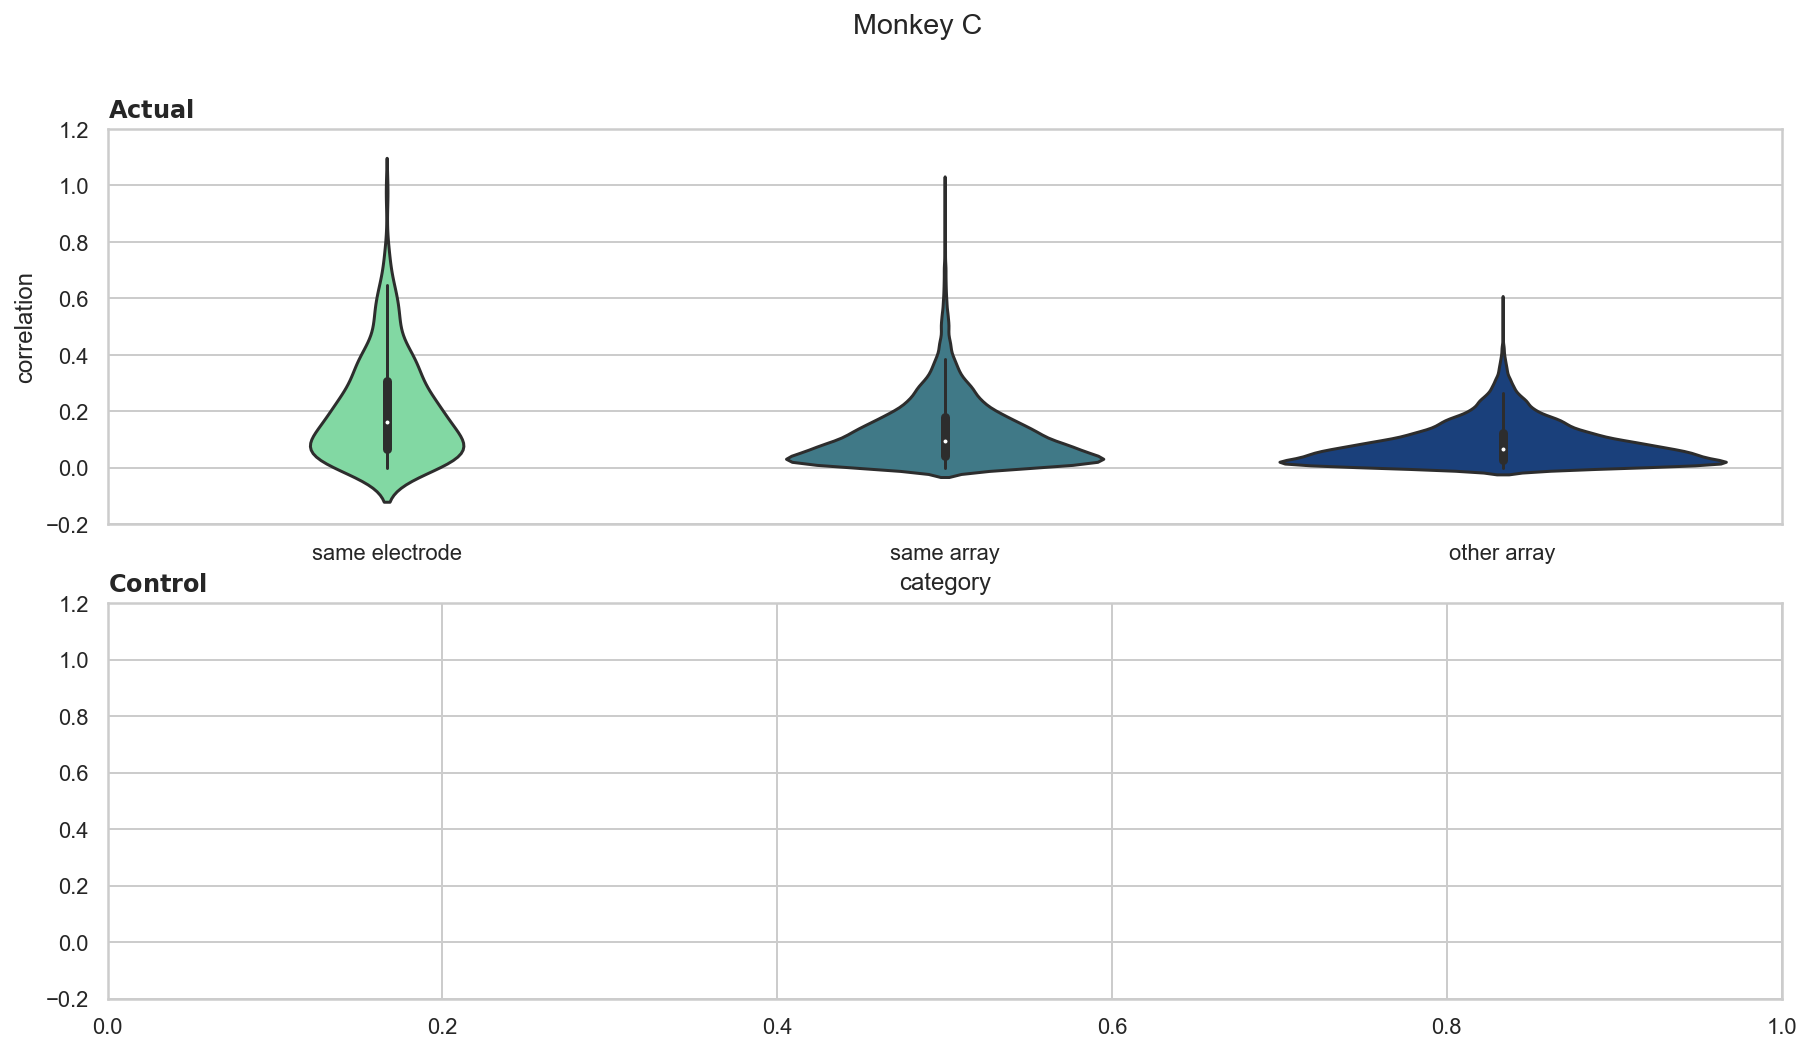

In [40]:
sns.set_theme(style='whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#74E6A0', '#348093', '#0A3C8B'])

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
fig.suptitle(f'Monkey {monkey}')
axs[0].set_title(r'$\bf{Actual}$', loc='left')
axs[1].set_title(r'$\bf{Control}$', loc='left')
axs[0].set_ylim([-0.2, 1.2])
axs[1].set_ylim([-0.2, 1.2])

sns.violinplot(x='category', y='correlation', data=df_emp, order=['same electrode', 'same array', 'other array'], orient='v', ax=axs[0])
sns.violinplot(x='category', y='correlation', data=df_con, order=['same electrode', 'same array', 'other array'], saturation=0.3, ax=axs[1])
sns.despine()

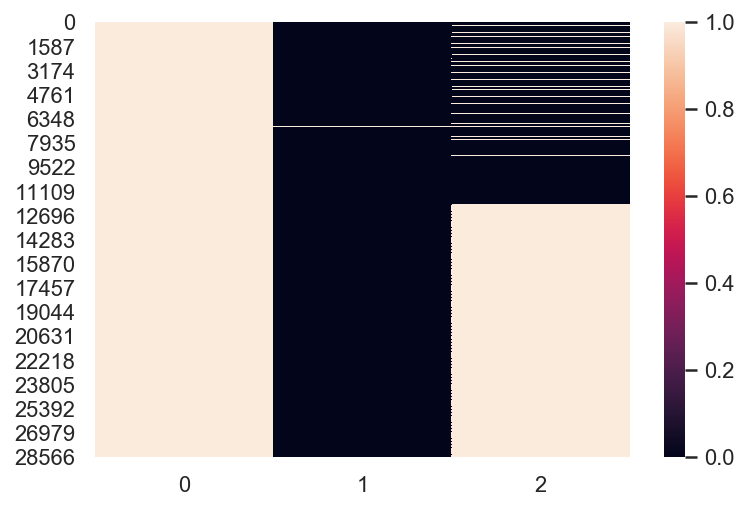

In [49]:
sns.heatmap(X)

In [53]:
df_emp['correlation']

0        0.090572
1        0.089930
2        0.164692
3        0.097482
4        0.105726
           ...   
30130    0.025391
30131    0.295886
30132    0.020190
30133    0.118874
30134    0.043156
Name: correlation, Length: 30135, dtype: float64

In [52]:
df_emp['distance'] == 0

0        False
1        False
2        False
3        False
4        False
         ...  
30130    False
30131    False
30132     True
30133     True
30134     True
Name: distance, Length: 30135, dtype: bool

In [50]:
Y

0        0.090572
1        0.089930
2        0.164692
3        0.097482
4        0.105726
           ...   
30130    0.025391
30131    0.295886
30132    0.020190
30133    0.118874
30134    0.043156
Name: correlation, Length: 30135, dtype: float64

In [110]:
.shape

(30135, 3)

In [47]:
# Construct X (the model needs an intercept so we add a column of ones)
X = np.vstack((np.ones_like(df_emp['correlation']), df_emp['distance'] == 0, df_emp['distance'] < OTHER_ARRAY_D)).T

Y = df_emp['correlation']

# Fit and print summary
model = sm.OLS(Y, X, hasconst=True)

res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            correlation   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     614.4
Date:                Sun, 22 Aug 2021   Prob (F-statistic):          2.88e-262
Time:                        15:16:19   Log-Likelihood:                 24825.
No. Observations:               30135   AIC:                        -4.964e+04
Df Residuals:                   30132   BIC:                        -4.962e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0861      0.001     83.144      0.0

In [111]:
res.params.shape

(3,)

In [34]:
'''Control test for shuffled data'''

# Construct X (the model needs an intercept so we add a column of ones)
X = np.vstack((np.ones_like(df_con['correlation']), df_con['distance'] == 0, df_con['distance'] < OTHER_ARRAY_D)).T

# Fit and print summary
res = sm.OLS(df_con['correlation'], X, hasconst=True).fit()
print(res.summary())

NameError: name 'df_con' is not defined

### 3.3.2 Continuous categories 

- Now we add intervals for the pairwise _within_ comparisons 

In [52]:
df_emp['within distance'] = pd.cut(df_emp['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

df_con['within distance'] = pd.cut(df_con['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

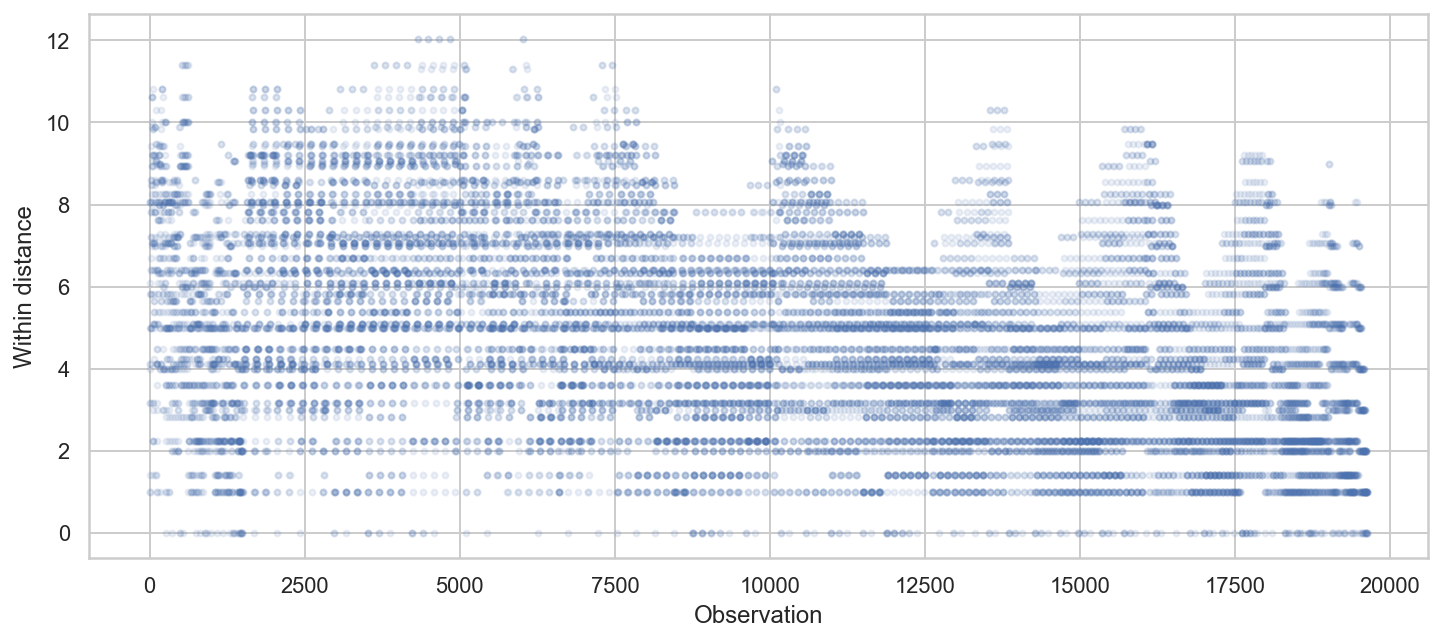

In [53]:
mask = np.where(D_emp < OTHER_ARRAY_D)

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(D_emp[mask].T, '.', alpha=0.1, color='b')
axs.set_ylabel('Within distance')
axs.set_xlabel('Observation');

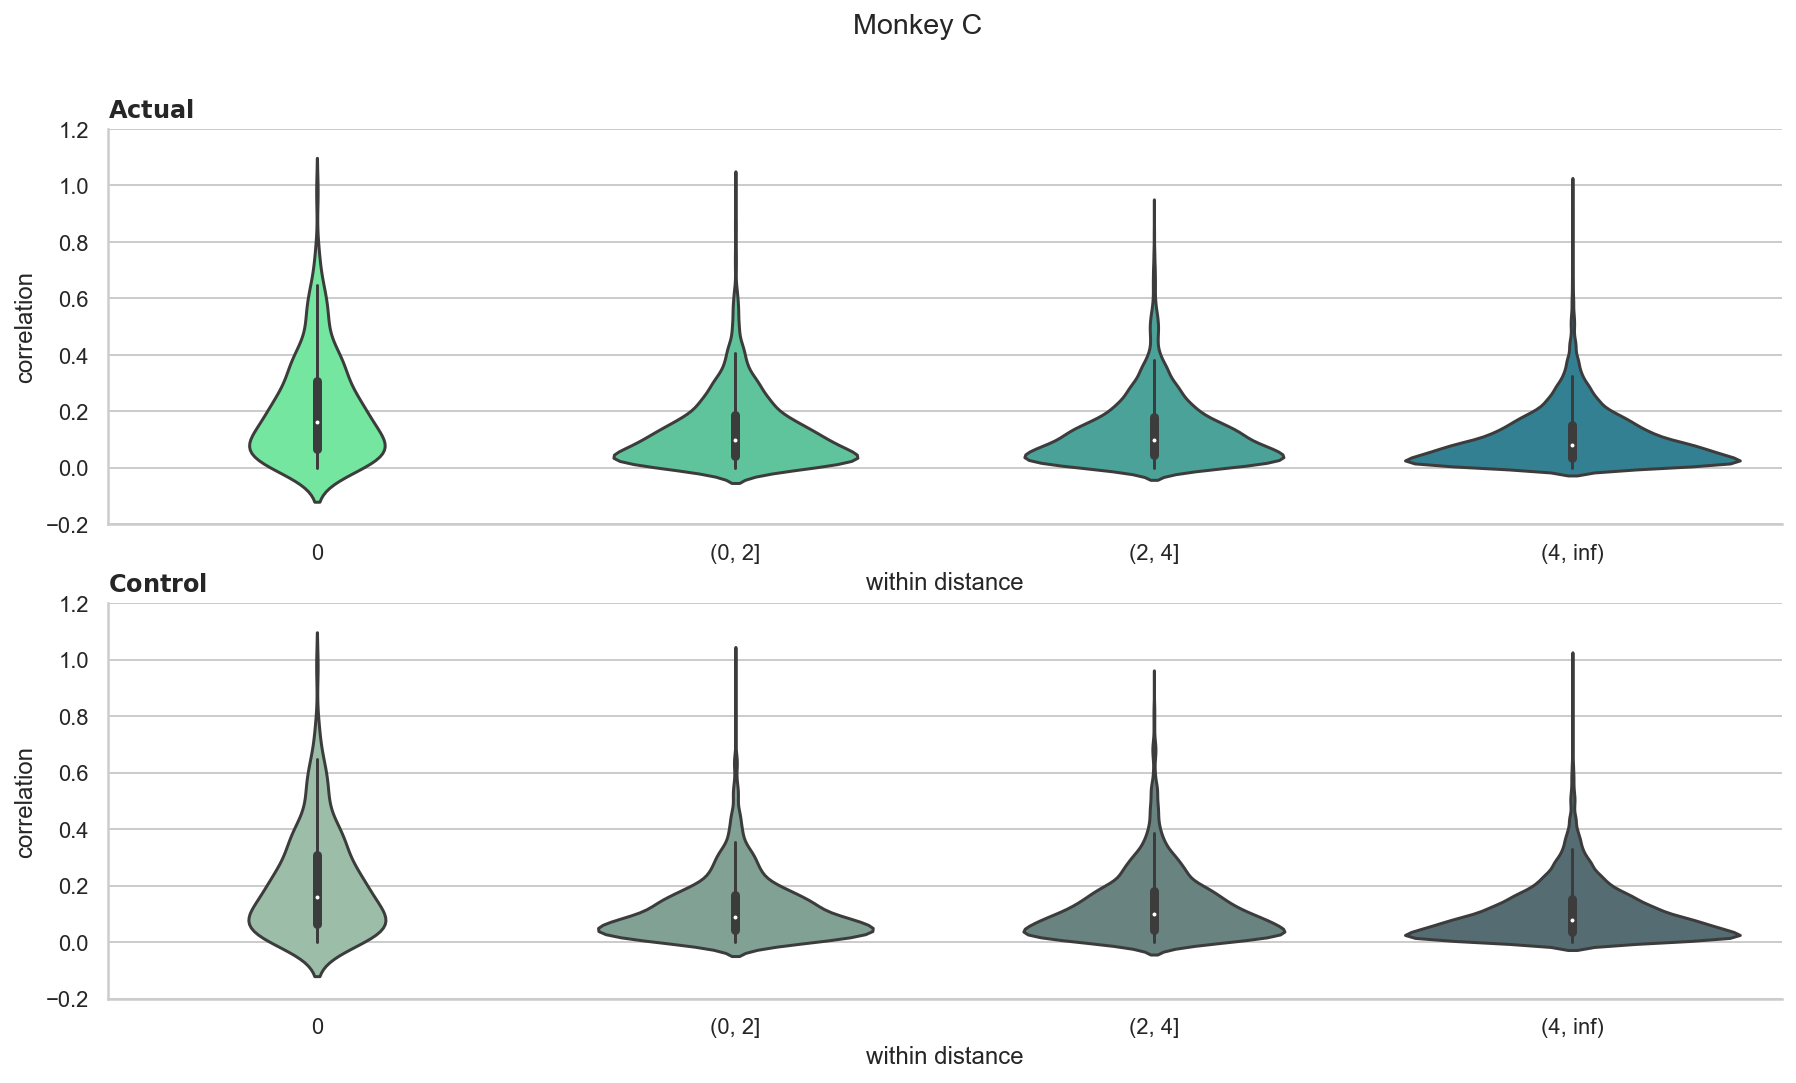

In [54]:
''' Show the distributions for each respective interval '''

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#74E6A0', '#5FC49C', '#4AA298', '#348093', '#1F5E8F', '#0A3C8B'])

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
fig.suptitle(f'Monkey {monkey}')

axs[0].set_title(r'$\bf{Actual}$', loc='left')
axs[1].set_title(r'$\bf{Control}$', loc='left')
axs[0].set_ylim([-0.2, 1.2])
axs[1].set_ylim([-0.2, 1.2])

sns.violinplot(x='within distance', y='correlation', data=df_emp, scale='area', inner='box', saturation=1, ax=axs[0])
sns.violinplot(x='within distance', y='correlation', data=df_con, scale='area', inner='box', saturation=0.3, ax=axs[1])

sns.despine()

In [64]:
df_emp['distance'].apply(lambda x: 0 < x <= 2).mean()

0.07300481168076987

In [57]:
df_X = pd.DataFrame({
    'constant' : np.ones(shape=(df_emp.shape[0], )),
    'OA Δconstant' : (df_emp['on array'] == 'OA') + 0,
    'PMd Δconstant' : (df_emp['on array'] == 'PMd') + 0,
    'd in (0, 2]' : df_emp['distance'].apply(lambda x: 0 < x <= 2) + 0,
    'd in (2, 4]' : df_emp['distance'].apply(lambda x: 2 < x <= 4) + 0,
    'd in (4, inf)' : df_emp['distance'].apply(lambda x: 4 < x < OTHER_ARRAY_D) + 0,
})

In [58]:
df_X_control = pd.DataFrame({
    'constant' : np.ones(shape=(df_con.shape[0], )),
    'OA Δconstant' : (df_con['on array'] == 'OA') + 0,
    'PMd Δconstant' : (df_con['on array'] == 'PMd') + 0,
    'd in (0, 2]' : df_con['distance'].apply(lambda x: 0 < x <= 2) + 0,
    'd in (2, 4]' : df_con['distance'].apply(lambda x: 2 < x <= 4) + 0,
    'd in (4, inf)' : df_con['distance'].apply(lambda x: 4 < x < OTHER_ARRAY_D) + 0,
})

In [59]:
df_X.head()

,constant,OA Δconstant,PMd Δconstant,"d in (0, 2]","d in (2, 4]","d in (4, inf)"
0,1.0,0,0,1,0,0
1,1.0,0,0,0,1,0
2,1.0,0,0,1,0,0
3,1.0,0,0,1,0,0
4,1.0,0,0,0,1,0


In [60]:
df_X.sum(axis=0) # number of samples per category

constant         30135.0
OA Δconstant     10505.0
PMd Δconstant    18145.0
d in (0, 2]       2200.0
d in (2, 4]       5026.0
d in (4, inf)    12174.0
dtype: float64

In [61]:
res = sm.OLS(df_emp['correlation'], df_X, hasconst=True).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            correlation   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     282.8
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          1.22e-296
Time:                        10:40:25   Log-Likelihood:                 24914.
No. Observations:               30135   AIC:                        -4.982e+04
Df Residuals:                   30129   BIC:                        -4.977e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant          0.1733      0.007     23.327

In [62]:
res_control = sm.OLS(df_emp['correlation'], df_X_control, hasconst=True).fit()
print(res_control.summary())

                            OLS Regression Results                            
Dep. Variable:            correlation   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     283.2
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          4.46e-297
Time:                        10:40:43   Log-Likelihood:                 24915.
No. Observations:               30135   AIC:                        -4.982e+04
Df Residuals:                   30129   BIC:                        -4.977e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant          0.1730      0.007     23.279

In [104]:
df_emp.loc[(df_emp['on array'] == 'OA'), 'correlation'].mean()

0.08612815454328232

In [105]:
# df_emp.loc[np.where((df_emp['on array'] == 'M1') & (df_emp['distance'] == 0)), 'correlation'].mean()
df_emp.loc[np.where((df_emp['on array'] == 'M1')), 'correlation'].mean()

0.09492248241185502

In [107]:
df_emp.loc[(df_emp['on array'] == 'PMd') & (df_emp['distance'] <= 2), 'correlation'].mean()

0.14278899740130718

In [106]:
pd.DataFrame(np.corrcoef(df_X.values.T))

,0,1,2,3,4,5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,-0.899926,-0.205293,-0.327291,-0.602267
2,NaN,-0.899926,1.000000,0.191637,0.304398,0.531904
3,NaN,-0.205293,0.191637,1.000000,-0.125555,-0.231041
4,NaN,-0.327291,0.304398,-0.125555,1.000000,-0.368339
5,NaN,-0.602267,0.531904,-0.231041,-0.368339,1.000000


In [92]:
# df_X = pd.DataFrame({
#     'constant' : np.ones(shape=(df_emp.shape[0], )),
#     'OA Δconstant' : (df_emp['on array'] == 'OA') + 0,
#     'PMd Δconstant' : (df_emp['on array'] == 'PMd') + 0,
#     'd = 0' : df_emp['d = 0'] + 0,
#     'd <= 3' : df_emp['d <= 3'] + 0,
#     'd <= 6' : df_emp['d <= 6'] + 0,
#     'd <= 9' : df_emp['d <= 9'] + 0
# })
# df_X['Δ PMd x {d = 0}'] = df_X['PMd Δconstant'] * df_X['d = 0'] + 0
# df_X['Δ PMd x {d <= 3}'] = df_X['PMd Δconstant'] * df_X['d <= 3'] + 0
# df_X['Δ PMd x {d <= 6}'] = df_X['PMd Δconstant'] * df_X['d <= 6'] + 0
# df_X['Δ PMd x {d <= 9}'] = df_X['PMd Δconstant'] * df_X['d <= 9'] + 0
# df_X.head()

In [93]:
# # Convert to pandas dataframe for convenience
# df_gen = pd.DataFrame(data={'correlation': abs(C_gen), 'distance': D_gen, 'on array': A_gen})

# df_gen['category'] = df_gen['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
# df_gen['d = 0'] = df_gen['distance'].apply(lambda x: x == 0)
# df_gen['d in (0,3]'] = df_gen['distance'].apply(lambda x: 0 < x <= 3)
# df_gen['d in (3,6]'] = df_gen['distance'].apply(lambda x: 3 < x <= 6)
# df_gen['d in (6,9]'] = df_gen['distance'].apply(lambda x: 6 < x <= 9)
# df_gen['d > 9'] = df_gen['distance'].apply(lambda x: 9 < x < OTHER_ARRAY_D)

In [87]:
# # Make within categories using specified intervals
# df_emp['d = 0'] = df_emp['distance'].apply(lambda x: x == 0)
# df_emp['d <= 3'] = df_emp['distance'].apply(lambda x: 0 <= x <= 3)
# df_emp['d <= 6'] = df_emp['distance'].apply(lambda x: 0 <= x <= 6)
# df_emp['d <= 9'] = df_emp['distance'].apply(lambda x: 0 <= x <= 9)

### 

## 4 Run ANOVA tests for all sessions and across PCs

In [13]:
''' 
Parameters 
'''
OTHER_ARRAY_D = 50 # Distance value to indicate other array
exp_var_levels = np.arange(0.4, 0.85, 0.05)
sessions_alphas = []
sessions_beta1 = []
sessions_beta2 = []
sessions_pcs = []

In [15]:
'''
Note: VR sessions have typically more neurons than CF sessions
'''

sessions = [
 'Chewie_CO_VR_2016-09-09.mat', # File Matt used to generate initial figures
 'Chewie_CO_VR_2016-09-12.mat',
 'Chewie_CO_VR_2016-09-14.mat',
 'Chewie_CO_VR_2016-10-06.mat',
 'Mihili_CO_VR_2014-03-03.mat',
 'Mihili_CO_VR_2014-03-04.mat',
 'Mihili_CO_VR_2014-03-06.mat',
 'Chewie_CO_FF_2016-09-15.mat',
 'Chewie_CO_FF_2016-09-21.mat',
 'Chewie_CO_FF_2016-10-05.mat',
 'Chewie_CO_FF_2016-10-07.mat',
 'Mihili_CO_FF_2014-02-03.mat',
 'Mihili_CO_FF_2014-02-17.mat',
 'Mihili_CO_FF_2014-02-18.mat',
 'Mihili_CO_FF_2014-03-07.mat'
]

In [16]:
warnings.filterwarnings('ignore')

for s in pbar(range(len(sessions))):

    session = sessions[s]
    print('------------------------------')
    print(f'Selected session: {session}')
    print('------------------------------')

    # Data path
    df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)

    # Get the date of the session and monkey name for plotting later
    date = '-'.join(re.findall('[0-9]+', session))
    monkey = session[:1]

    # ==== PREPROCESSING ====
    td = combine_time_bins(df, n_bins=3)
    td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
    td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)
    td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
    td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')
    td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')
    td = add_firing_rates(td, 'smooth', std=0.05)
    td = td.loc[td['epoch'] == 'BL']

    # === PCA ===
    num_neurons = td.both_rates[0].shape[1]
    # Perform PCA on the trial concatenated trialdata
    td, model_m1pmd = tools.dim_reduce(td, PCA(n_components=num_neurons), 'both_rates', 'both_pca', return_model=True)
    m1pmd_pcs = model_m1pmd.components_.T

    # === COMPUTE COEFFICIENTS FOR RANGE OF PCs ===
    # Get PCs for all explained variances
    k_range = [np.argmax(model_m1pmd.explained_variance_ratio_.cumsum() > exp_var_levels[i]) for i in range(len(exp_var_levels))]

    s_alphas = []
    s_beta1 = []
    s_beta2 = []
    
    for i, K in enumerate(k_range):
        
        print(f'{i} OLS with {K} PCs')
        L = m1pmd_pcs[:, :K]
        
        # Compute correlations and physical distances
        C, D = get_correlations(L, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

        # Run OLS regression
        y = C
        X = np.vstack((np.ones_like(y), D == 0, D < OTHER_ARRAY_D)).T
        y = y.reshape((len(y), 1))
        res = sm.OLS(y, X, hasconst=True).fit()
        
        s_alphas.append(res.params[0])
        s_beta1.append(res.params[1])
        s_beta2.append(res.params[2])
        
    sessions_alphas.append(s_alphas)
    sessions_beta1.append(s_beta1)
    sessions_beta2.append(s_beta2)
    sessions_pcs.append(k_range)

  0%|          | 0/15 [00:00<?, ?it/s]

------------------------------
Selected session: Chewie_CO_VR_2016-09-09.mat
------------------------------
0 OLS with 10 PCs
1 OLS with 14 PCs
2 OLS with 20 PCs
3 OLS with 27 PCs
4 OLS with 36 PCs
5 OLS with 47 PCs
6 OLS with 59 PCs
7 OLS with 72 PCs
8 OLS with 88 PCs


  7%|▋         | 1/15 [00:50<11:41, 50.13s/it]

------------------------------
Selected session: Chewie_CO_VR_2016-09-12.mat
------------------------------
0 OLS with 13 PCs
1 OLS with 19 PCs
2 OLS with 27 PCs
3 OLS with 37 PCs
4 OLS with 48 PCs
5 OLS with 61 PCs
6 OLS with 75 PCs
7 OLS with 91 PCs
8 OLS with 109 PCs


 13%|█▎        | 2/15 [01:56<11:56, 55.11s/it]

------------------------------
Selected session: Chewie_CO_VR_2016-09-14.mat
------------------------------
0 OLS with 15 PCs
1 OLS with 23 PCs
2 OLS with 34 PCs
3 OLS with 48 PCs
4 OLS with 64 PCs
5 OLS with 81 PCs
6 OLS with 101 PCs
7 OLS with 124 PCs
8 OLS with 149 PCs


 20%|██        | 3/15 [03:30<13:18, 66.57s/it]

------------------------------
Selected session: Chewie_CO_VR_2016-10-06.mat
------------------------------
0 OLS with 15 PCs
1 OLS with 22 PCs
2 OLS with 30 PCs
3 OLS with 39 PCs
4 OLS with 51 PCs
5 OLS with 63 PCs
6 OLS with 78 PCs
7 OLS with 94 PCs
8 OLS with 112 PCs


 27%|██▋       | 4/15 [04:16<11:04, 60.44s/it]

------------------------------
Selected session: Mihili_CO_VR_2014-03-03.mat
------------------------------
0 OLS with 8 PCs
1 OLS with 10 PCs
2 OLS with 13 PCs
3 OLS with 16 PCs
4 OLS with 20 PCs
5 OLS with 24 PCs
6 OLS with 29 PCs
7 OLS with 35 PCs
8 OLS with 42 PCs


 33%|███▎      | 5/15 [04:32<07:51, 47.14s/it]

------------------------------
Selected session: Mihili_CO_VR_2014-03-04.mat
------------------------------
0 OLS with 9 PCs
1 OLS with 12 PCs
2 OLS with 16 PCs
3 OLS with 20 PCs
4 OLS with 24 PCs
5 OLS with 30 PCs
6 OLS with 36 PCs
7 OLS with 43 PCs
8 OLS with 51 PCs


 40%|████      | 6/15 [04:47<05:38, 37.66s/it]

------------------------------
Selected session: Mihili_CO_VR_2014-03-06.mat
------------------------------
0 OLS with 11 PCs
1 OLS with 15 PCs
2 OLS with 19 PCs
3 OLS with 23 PCs
4 OLS with 28 PCs
5 OLS with 34 PCs
6 OLS with 41 PCs
7 OLS with 49 PCs
8 OLS with 58 PCs


 47%|████▋     | 7/15 [05:20<04:49, 36.24s/it]

------------------------------
Selected session: Chewie_CO_FF_2016-09-15.mat
------------------------------
0 OLS with 13 PCs
1 OLS with 20 PCs
2 OLS with 30 PCs
3 OLS with 42 PCs
4 OLS with 57 PCs
5 OLS with 73 PCs
6 OLS with 91 PCs
7 OLS with 112 PCs
8 OLS with 135 PCs


 53%|█████▎    | 8/15 [07:14<06:56, 59.52s/it]

------------------------------
Selected session: Chewie_CO_FF_2016-09-21.mat
------------------------------
0 OLS with 14 PCs
1 OLS with 21 PCs
2 OLS with 29 PCs
3 OLS with 40 PCs
4 OLS with 53 PCs
5 OLS with 67 PCs
6 OLS with 84 PCs
7 OLS with 102 PCs
8 OLS with 123 PCs


 60%|██████    | 9/15 [08:59<07:19, 73.21s/it]

------------------------------
Selected session: Chewie_CO_FF_2016-10-05.mat
------------------------------
0 OLS with 13 PCs
1 OLS with 18 PCs
2 OLS with 25 PCs
3 OLS with 34 PCs
4 OLS with 45 PCs
5 OLS with 57 PCs
6 OLS with 71 PCs
7 OLS with 86 PCs
8 OLS with 104 PCs


 67%|██████▋   | 10/15 [10:21<06:18, 75.74s/it]

------------------------------
Selected session: Chewie_CO_FF_2016-10-07.mat
------------------------------
0 OLS with 13 PCs
1 OLS with 17 PCs
2 OLS with 23 PCs
3 OLS with 31 PCs
4 OLS with 40 PCs
5 OLS with 51 PCs
6 OLS with 63 PCs
7 OLS with 76 PCs
8 OLS with 91 PCs


 73%|███████▎  | 11/15 [11:11<04:32, 68.07s/it]

------------------------------
Selected session: Mihili_CO_FF_2014-02-03.mat
------------------------------
0 OLS with 6 PCs
1 OLS with 8 PCs
2 OLS with 10 PCs
3 OLS with 13 PCs
4 OLS with 16 PCs
5 OLS with 20 PCs
6 OLS with 24 PCs
7 OLS with 30 PCs
8 OLS with 36 PCs


 80%|████████  | 12/15 [11:34<02:43, 54.56s/it]

------------------------------
Selected session: Mihili_CO_FF_2014-02-17.mat
------------------------------
0 OLS with 9 PCs
1 OLS with 12 PCs
2 OLS with 15 PCs
3 OLS with 19 PCs
4 OLS with 24 PCs
5 OLS with 30 PCs
6 OLS with 37 PCs
7 OLS with 45 PCs
8 OLS with 55 PCs


 87%|████████▋ | 13/15 [12:09<01:37, 48.66s/it]

------------------------------
Selected session: Mihili_CO_FF_2014-02-18.mat
------------------------------
0 OLS with 8 PCs
1 OLS with 11 PCs
2 OLS with 15 PCs
3 OLS with 19 PCs
4 OLS with 23 PCs
5 OLS with 29 PCs
6 OLS with 36 PCs
7 OLS with 44 PCs
8 OLS with 54 PCs


 93%|█████████▎| 14/15 [12:47<00:45, 45.46s/it]

------------------------------
Selected session: Mihili_CO_FF_2014-03-07.mat
------------------------------
0 OLS with 8 PCs
1 OLS with 10 PCs
2 OLS with 13 PCs
3 OLS with 16 PCs
4 OLS with 20 PCs
5 OLS with 24 PCs
6 OLS with 29 PCs
7 OLS with 34 PCs
8 OLS with 41 PCs


100%|██████████| 15/15 [12:59<00:00, 51.95s/it]


In [19]:
exp_var_levels_str = ['40', '45', '50', '55', '60', '65', '70', '75', '80', '85']

sns.set_theme(style='whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FF4F4F', '#E3606C', '#C6718A', '#AA82A7', '#8D93C4', '#71A4E2', '#54B5FF'])
plt.rcParams.update({'font.size': 15})

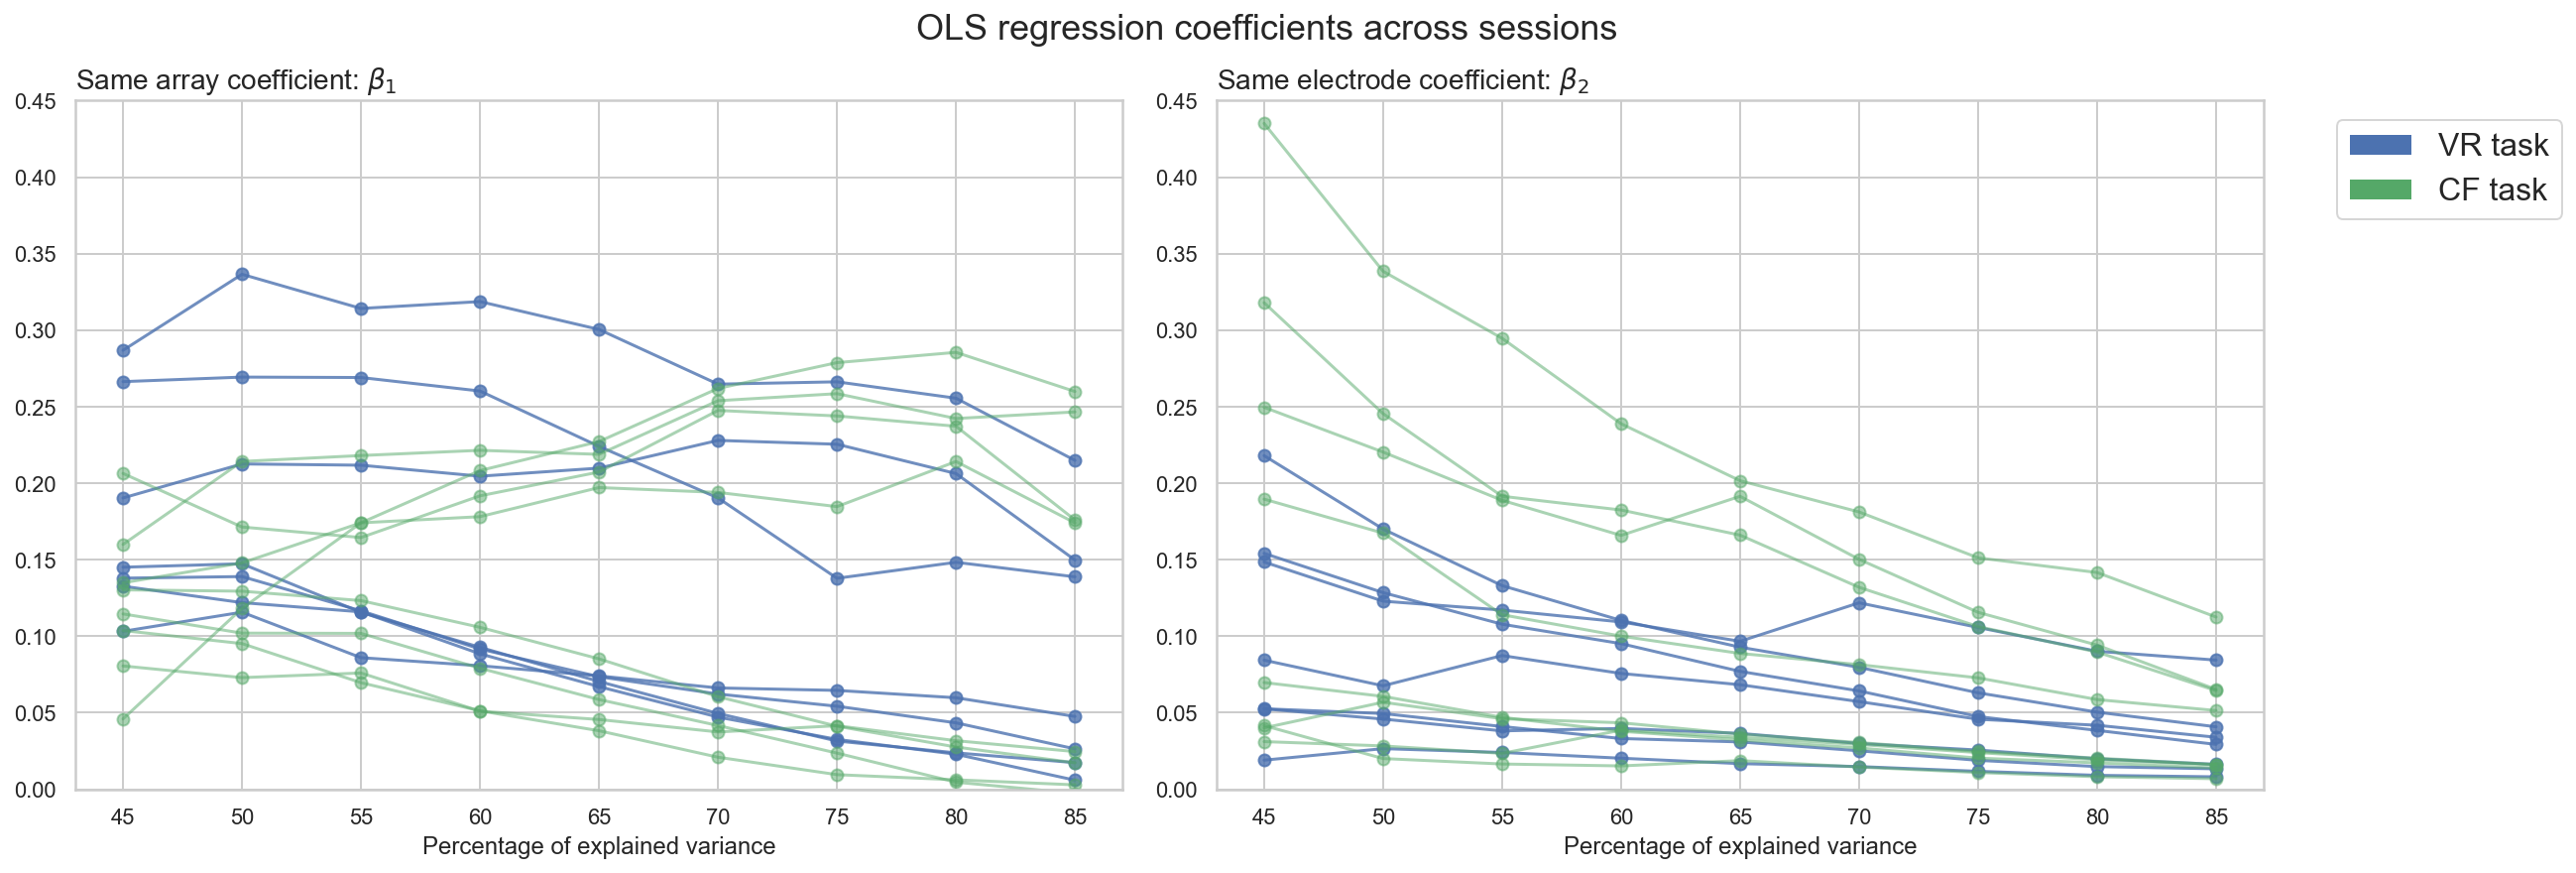

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

fig.suptitle('OLS regression coefficients across sessions', y=1.02)

axs[0].set_title(r'Same array coefficient: $\beta_1$', loc='left', fontsize=14)
for i, s in enumerate(sessions_beta1): 
    if i <= 6: axs[0].plot(s, 'o-', color='b', alpha=0.8)
    else: axs[0].plot(s, 'o-', color='g', alpha=0.5)
axs[0].set_xlabel('Percentage of explained variance')
axs[0].set_xticklabels(exp_var_levels_str)
axs[0].set_ylim([0, 0.45])

axs[1].set_title(r'Same electrode coefficient: $\beta_2$', loc='left', fontsize=14)
for i, s in enumerate(sessions_beta2): 
    if i <= 6: axs[1].plot(s, 'o-', color='b', alpha=0.8) # Plot VR tasks in blue
    else: axs[1].plot(s, 'o-', color='g', alpha=0.5) # CF tasks in green
axs[1].set_xlabel('Percentage of explained variance')
axs[1].set_xticklabels(exp_var_levels_str)
axs[1].set_ylim([0, 0.45])

legend_elements = [Patch(facecolor='b',label='VR task'), Patch(facecolor='g',label='CF task')]
axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.3, 0.9), fontsize=16)

fig.tight_layout()

[Look at this](https://seaborn.pydata.org/tutorial/relational.html)

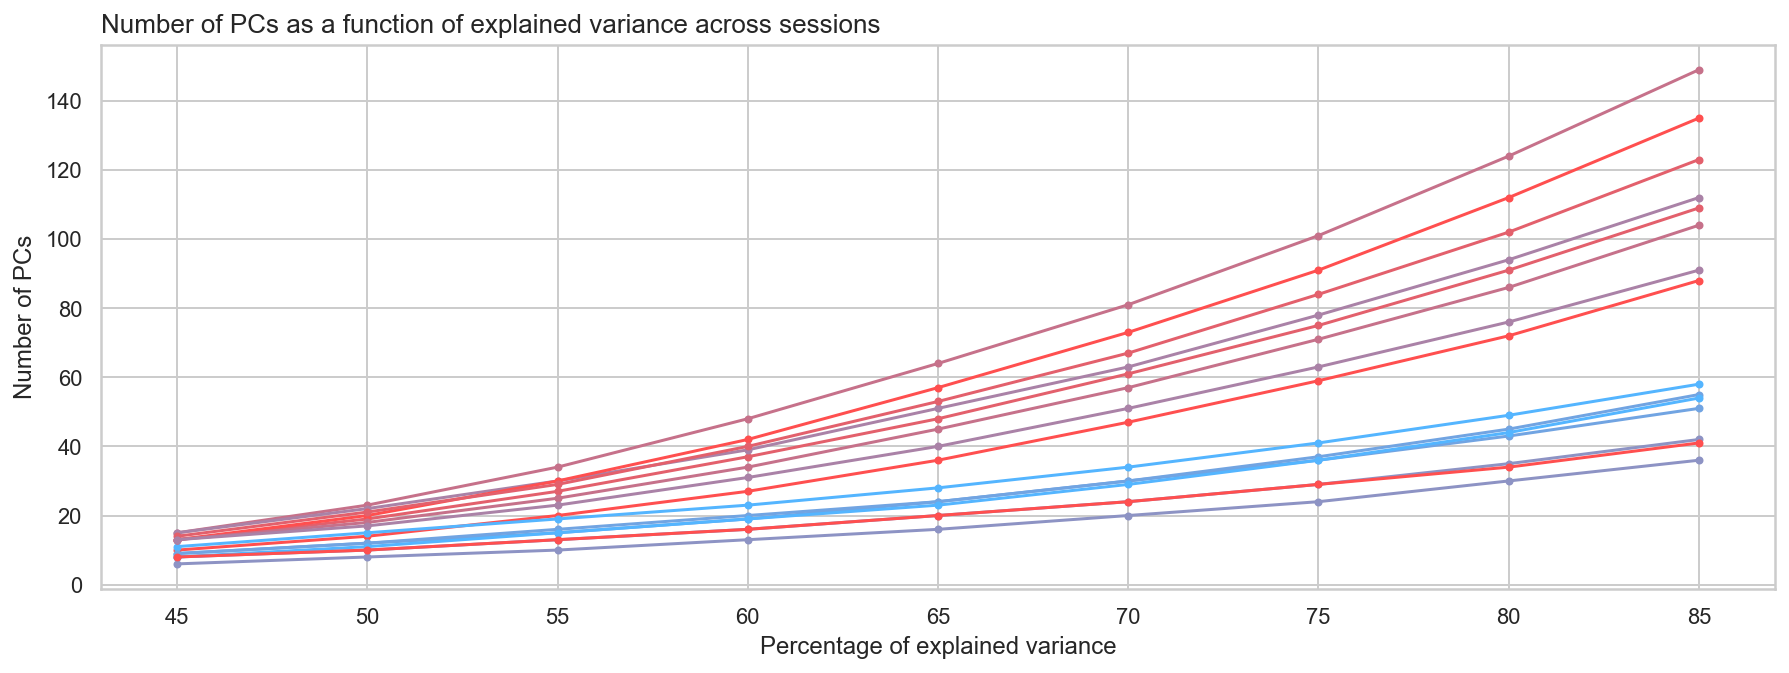

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axs.set_title('Number of PCs as a function of explained variance across sessions', loc='left', fontsize=13)

axs.set_xlabel('Percentage of explained variance')
axs.set_ylabel('Number of PCs')
axs.set_xticklabels(exp_var_levels_str)
for i in sessions_pcs: axs.plot(i, '.-');